# Experiment 1: Analysis
The purpose of this notebook is to analyze the learned representations and dynamics of trained RNNs.

## Imports

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sinusoid.model import VanillaRNN
from sinusoid.task import PatternDataset

## Load model

In [2]:
experiment_folder = "../../results/experiment_1"

In [3]:
model = VanillaRNN(1, 1, 5)
model_path = os.path.join(experiment_folder, "task_43/best_model_freqs_6.pth")
state_dict = torch.load(model_path, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

<All keys matched successfully>

## Load dataset

In [4]:
dataset_full = PatternDataset(np.linspace(0.1, 0.6, 51), 100)
dataloader_full = DataLoader(dataset_full, batch_size=51)

dataset_partial = PatternDataset([0.3], 100)
dataloader_partial = DataLoader(dataset_partial, batch_size=1)

## PCA

In [5]:
all_rates = []
with torch.no_grad():
    for _ in range(100):
        X, y = list(dataloader_partial)[0]
        outputs, rates = model(X, model.init_random(1))
        all_rates.append(rates.numpy())

rates = np.concatenate(all_rates)

In [6]:
rates_flat = np.reshape(rates, (100*100, 5))
pca = PCA(n_components=2)
pca.fit(rates_flat)

PCA(n_components=2)

In [7]:
rates_0 = pca.transform(rates[0,:,:])
rates_1 = pca.transform(rates[1,:,:])
rates_2 = pca.transform(rates[2,:,:])
rates_3 = pca.transform(rates[3,:,:])

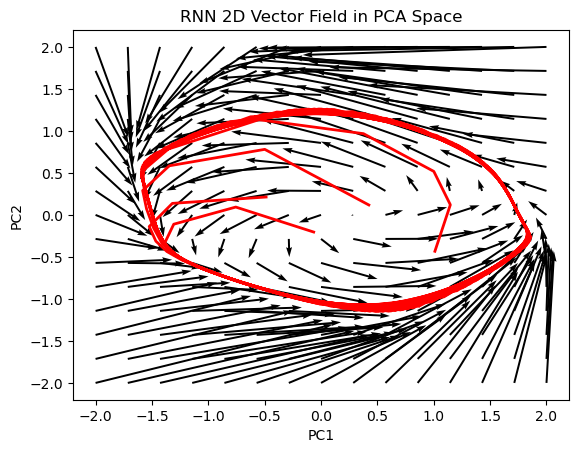

In [8]:
# 1. Grid the PCA space
x = np.linspace(-2, 2, 15)  # Adjust these based on your PCA space limits
y = np.linspace(-2, 2, 15)
X, Y = np.meshgrid(x, y)

U = np.zeros(X.shape)
V = np.zeros(Y.shape)

# 2. & 3. Compute RNN outputs and derivatives
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = np.array([[X[i,j], Y[i,j]]])
        original_space_point = pca.inverse_transform(point)
        
        with torch.no_grad():
            inputs, y = list(dataloader_partial)[0]
            _, rates = model(inputs, torch.unsqueeze(torch.tensor(original_space_point), 0).float())
            rate_in_pca = pca.transform(torch.squeeze(rates).numpy())
            
        U[i,j] = rate_in_pca[0, 0] - X[i,j]
        V[i,j] = rate_in_pca[0, 1] - Y[i,j]

# 4. Plot the vector field
plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1)
plt.plot(rates_0[:,0], rates_0[:,1], 'r-', lw=2, label="0")
plt.plot(rates_1[:,0], rates_1[:,1], 'r-', lw=2, label="1")
plt.plot(rates_2[:,0], rates_2[:,1], 'r-', lw=2, label="2")
plt.plot(rates_3[:,0], rates_3[:,1], 'r-', lw=2, label="3")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('RNN 2D Vector Field in PCA Space')
plt.savefig('limit_cycle.png')
plt.show()